## DECam $(g-i)$ and $(g-z)$ analysis

Version 8 Feb 2025, J. Jensen. Fixed NED extinction retrieval. 28 Jan 2025, fixed bug that misplotted c0 annulus.

Compute the colors by taking the magnitudes in g, i, and z of the total of the good pixels in annuli first and subtracting, not computing colors individually by pixel and then averaging like before.

The uncertainties are computed from the variance images for the same pixels. Regions with rms > threshold (0.5 mag) are excluded and no g-z or g-i values are reported (NaN).

The photometric uncertainty and extinction correction uncertainty are added in quadrature.

DECam images should have already been retrieved and processed using Downloads_DECam script. 

This script gets the extinction values from NED. 
The script uses SExtractor to identify stars and other objects, and make a mask automatically. 
It looks for an existing DECam mask for large or saturated objects and other image defects.

DECam images have 0.2637 arcsec/pix center, 0.2626 edge; these galaxies could be anywhere
on the original camera, so we use 0.263 arcsec pixels.

In [1]:
import sys, os
import datetime

pysbf_path = "/Users/Joe/data/sbf/"
sys.path.insert(0, pysbf_path)
from pysbf import *

# Name convention for manually-created masks, if any:
DC_manual = 'dc.mask'

configFolder = pysbf_path + "pysbf/config/sextractor/"
resetSEmask = False

# If the automatic masking procedure using SExtractor fails, try using the manual DC mask only (DConly=True)
DConly = False
# If there are no i-band images, we should continue with g-z only.
noi = False

version = "DECam-colors 2025-02-08"

## Photometric uncertainty

In [2]:
# Fractional uncertainty to assign to extinction values
extfrac = 0.1

# Dey et al. 2019, Overview of DESI Legacy Imaging Surveys, has 0.01 to 0.02 mag
# Burke et al. 2018, AJ, 155:41 states DES statistical uncertainties of 0.006 to 0.007 mag. Single CCD gray 0.001 mag, consitent with VAR images
photouncertg = 0.0073
photouncerti = 0.0059
photouncertz = 0.0073


## Object Initialization

In [3]:
# This is the radial region to fit with elliprof. Set to zero for automatic calculation. Set to explicit value if the default value doesn't work well.
r1 = str(100)
# Radial region to use for measuring the background. Set to zero for automatic calculation.
rsky = str(0)

# Location for the DECam calibrator images
# DC_root = '/Users/Joe/data/DECam/'
#----FCS calibrators---- (11712)
#-name = "ic1919"; r1=str(160)
#-name = "ic2006"; r1=str(160)
#-name = "n1344"; r1=str(150)
#-name = "n1374"; r1=str(200)
#-name = "n1375"; r1=str(120) #; DConly=True
#-name = "n1380"; r1=str(150); DConly=True
#-name = "n1399"; r1=str(200)
#-name = "n1404"; r1=str(200); DConly=True
#----VCS Calibrators----
#-name = "ic0798"; r1=str(80)
#-name = "ic0809"
#-name = "ic3019"
#-name = "ic3025"; r1=str(120)
#-name = "ic3032"; r1=str(80)
#-name = "ic3065"; r1=str(120)
#-name = "ic3101"
#-name = "ic3292"; r1=str(100)
#-name = "ic3328"; r1=str(70)
#-name = "ic3381"; r1=str(150)
#-name = "ic3383"
#-name = "ic3442"
#-name = "ic3461" 
#-name = "ic3468"; r1=str(80)
#-name = "ic3470"; r1=str(80)
#-name = "ic3487"
#-name = "ic3490"
#-name = "ic3492"; noi=True; DConly=True # the i-band image is missing the center; dust
#-name = "ic3501"
#-name = "ic3509"
#-name = "ic3586"; r1=str(90)
#-name = "ic3602"; r1=str(30) # something's wrong with this one
#-name = "ic3612"; r1=str(100)
#-name = "ic3633"; r1=str(80)
#-name = "ic3635"; r1=str(80)
#-name = "ic3647"; r1=str(90)
#-name = "ic3652"
#-name = "ic3653"
#-name = "ic3735"; r1=str(120)
#-name = "ic3773"
#-name = "ic3779"; r1=str(120)
#-name = "n4262"; r1=str(110) # dust, star formation
#-name = "n4267"; r1=str(120)
#-name = "n4309a"
#-name = "n4318"
#-name = "n4340"; r1=str(80) #ring galaxy
#-name = "n4350"; DConly=True; r1=str(200) # edge-on disk galaxy, saturated core
#-name = "n4352"; r1=str(120); DConly=True # disk galaxy
#-name = "n4371"; DConly=True; r1=str(100) # disky galaxy, ring/bar/warp 
#-name = "n4377"; DConly=True # close companion, saturated core
#-name = "n4379"; r1=str(120)
#-name = "n4387"; DConly=True
#-name = "n4417"; DConly=True; r1=str(100)
#-name = "n4434"; DConly=True; r1=str(100)
#-name = "n4435"; DConly=True  # dust, disk
#-name = "n4452"; r1=str(100) # thin edge on disk
#-name = "n4458"; DConly=True
#-name = "n4464"
#-name = "n4467"; r1=str(60)
#-name = "n4472"; r1=str(240)
#-name = "n4474"; r1=str(80); DConly=True
#-name = "n4476"
#-name = "n4478"; DConly=True
#-name = "n4479"
#-name = "n4482"
#-name = "n4483"; noi=True; DConly=True # i-band image is missing the galaxy core
#-name = "n4486a"; DConly=True #saturated near core
#-name = "n4486b"; DConly=True; r1=str(60)
#-name = "n4489"; r1=str(180); DConly=True
#-name = "n4515"; r1=str(120)
#-name = "n4528"; r1=str(100); DConly=True
#-name = "n4550"; r1=str(150); DConly=True
#-name = "n4551"
#-name = "n4564"; DConly=True
#-name = "n4570"; DConly=True
#-name = "n4578"
#-name = "n4612"; noi=True; DConly=True; r1=str(80)
#-name = "n4623"; DConly=True
#-name = "n4638"; DConly=True
#-name = "n4649"; r1 = str(250); DConly=True
#-name = "n4660"; DConly=True; r1=str(80)
#-name = "u7399a"; DConly=True; r1=str(80)
#-name = "u7436"
#-name = "u7580"
#-name = "u7854"
# Coma 11711
#-name = "n4874"
# GW NS merger
#-name = "n4993"; DConly=True; r1=str(120)
# JWST TRGB calibrators
# name = "n4374"
# name = "n4406"
# name = "n4621"
# name = "n4486"
#-name = "n4552"; r1=str(200); DConly=True
#-name = "n4697"; r1=str(200); DConly=True
# name = "n1549"
# name = "n3379"
 
# ---------MASSIVE+SN----------
#DC_root = '/Users/Joe/data/DECam/'
#-name = "ic2597"; r1=str(100)
#-name = "n0057"
#-name = "n0524"; noi=True
#-name = "n0533"
#-name = "n0545"; DConly=True; r1=str(30)
#-name = "n0547"; DConly=True; r1=str(40)
#-name = "n0809"; r1=str(150); DConly=True
#-name = "n1016"; r1=str(120)
#-name = "n1200"; r1=str(120)
#-name = "n1201"; DConly=True; r1=str(120)
#-name = "n1453"
# name = "n1600"; r1=str(150)
#-name = "n1684"
#-name = "n1700"
#-name = "n2513"
#-name = "n2672"; r1=str(100); DConly=True
#-name = "n2765"; DConly=True
#-name = "n2962"; DConly=True; r1=str(80)
#-name = "n3842"; DConly=True
#-name = "n4073"; r1=str(180)
#-name = "n4839"; r1=str(80)
#-name = "n5490"; DConly=True
#-name = "n5839"; noi=True; DConly=True # the i-band image is missing much of the galaxy. 
#-name = "n6964"; r1=str(80) # much of i-band is missing, but c0 and c1 are OK.

# ---------SNAP28----------
DC_root = '/Users/Joe/data/wfc3-16262/DECam/'  # for SNAP-28
# name = "WISEAJ192159.44-600234.4"; r1=str(80)
# name = "WISEAJ125011.54-411315.5"; r1=str(90) # aka "2MASS-J12501152-4113155"
# name = "eso185-g054"; r1=str(90)
name = "eso235-g049"
# name = "eso436-g045"; r1=str(60)
# name = "eso507-g025"; r1=str(100); DConly=True
# name = "ic4794"; r1=str(80)
###name = "ic4798"; r1=str(150)
###name = "ic4956"; r1=str(100)
# name = "ic5105"; r1=str(200); DConly=True
# name = "n0080"
# name = "n0380"; r1=str(100)
# name = "n0439"
# name = "n1490"
# name = "n4373"
# name = "n6653"; r1=str(100)
# name = "n6739"; DConly=True
#-name = "n6768"; r1=str(80)
#-name = "n6861"
#-name = "n6868"
#-name = "n7014"
# name = "pgc63905"
# name = "n0750"; DConly=True # double galaxy
# name = "n2418"; noi=True; DConly=True
#-name = "n2569"; noi=True
#-name = "n3070"
#-name = "n3091"
# name = "n3308"; r1=str(80)
# name = "n3311"; r1=str(170)
#-name = "n4825"
# name = "n4955"; r1=str(120)
# name = "n6577"; DConly=True # Most of the galaxy is missing from the z image; turned off elliprof and SExtractor
#-name = "n6968"
# name = "pgc158229"
# name = "pgc170207"

# ---------SNAP31----------
# DC_root = '/Users/Joe/data/wfc3-17436/DECam/'  # for SNAP-31
#-name = "n0050"
#-name = "n0194"
#-name = "n0193"
#-name = "n0277"
#-name = "n0541"
#-name = "n0564"
#-name = "n0883"
#-name = "ic1812"
#-name = "n1550"
#-name = "n1609"
#-name = "n1682"
#-name = 'n1710'
#-name = 'u03215'
#-name = 'n1713'
#-name = "n4782"; DConly=True # Double galaxy
#-name = "n5357"; r1=str(100)
#-name = "ic4842"; r1=str(100)
#-name = "n0641"
#-name = "eso197-g010"
##name = "eso153-g003"
# name = "n1322"
# name = "mcg-01-23-019"
# name = "n3222"
# name = "n3352"
# name = "n3771"; r1=str(100)
# name = "n3172"
# name = "n6375"; r1=str(100)
# name = "n6442"; r1=str(100)
# name = "eso141-g003"
# name = "u12179"
# name = "ic0574"
# name = "ic0642"
# name = "n0071"; DConly=True; r1=str(70) # Multiple companions and interactions
# name = "ic3426"

# ----------SN31-----------
# DC_root = '/Users/Joe/data/wfc3-17446/DECam/'  # for SN-31
# name = "cgcg-005-038"; r1=str(100)
# name = "cgcg-031-049"; noi=True
# name = "eso352-g057"
# name = "eso442-g015"
# name = "eso479-g007"; r1=str(80)
# name = "mcg-02-33-017"; r1=str(80) # spiral structure
# name = "cgcg-097-050"
# name = "u00402"; DConly=True; r1=str(80)
# name = "n0083"; noi=True; DConly=True
# name = "n1209"; DConly=True
# name = "n3332"
# name = "n3643"
# name = "n4169"
# name = "n4415"; r1=str(120)
# name = "n4636" ; DConly=True
# name = "n4767"; r1=str(120); DConly=True
# name = "n5018"; DConly=True # dusty one
# name = "n5222"; DConly=True # dusty
# name = "n5304"
# name = "n5419"
# name = "n7187"; r1=str(120)
# name = "u02829"; noi=True   

In [4]:
# This flag should be set to True while generating and fixing masks.
# Comment out this line once the masks are good, for re-running later (False by default).
resetSEmask = True

In [5]:
outFolder = DC_root + name + '/DC_Outputs_' + name + '/'
createDir(outFolder)
g_fits = DC_root + name + '/' + name + '_g.fits'
i_fits = DC_root + name + '/' + name + '_i.fits'
z_fits = DC_root + name + '/' + name + '_z.fits'
g_var = DC_root + name + '/' + name + '_gvar.fits'
i_var = DC_root + name + '/' + name + '_ivar.fits'
z_var = DC_root + name + '/' + name + '_zvar.fits'

if noi==True:
    i_fits = ''; i_var = ''

DC_mask = DC_root + name + '/' + name + '.mask'
if not os.path.exists(DC_mask):
    DC_mask = outFolder + '/' + name + '.mask' 
DC_manual = DC_root + name + '/' + name + DC_manual
DC_skymask = outFolder + '/' + name + 'dcsky.mask'
DC_circlemask = configFolder + 'dccircle.mask'

# If using only the manual mask:
if DConly==True:
    xcmd("cp "+DC_manual+" "+DC_mask, verbose=False)
    resetSEmask = False
    print('Using the DC mask only; please make sure all extraneous objects are masked.')
    
print("DECam files: ", g_fits, i_fits, z_fits)
print(g_var, i_var, z_var)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header

ra  = hdr["CRVAL1"]
dec = hdr["CRVAL2"]
nx = hdr["NAXIS1"]
ny = hdr["NAXIS2"]
xcenter = str(int(nx/2))
ycenter = str(int(ny/2))
xsize = str(nx)
ysize = str(ny)
if r1 == "0" :
    r1 = str(nx/20)
if rsky == "0":
    rsky = str(nx/3)

#print("RA [deg]: ",  ra)
#print("Dec [deg]: ", dec)
print("Size: ", nx, "x", ny)
#print("center: ", xcenter,ycenter)
#print("r1 = ", r1, "  rsky = ", rsky)


DECam files:  /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_g.fits /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_i.fits /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_z.fits
/Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_gvar.fits /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_ivar.fits /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049_zvar.fits
Size:  2837 x 2837


### Get Galaxy Info

In [6]:
ned = get_ned_info([name])
ned

if ned is not None:
    ra, dec = ned.iloc[0]["ra_dec"]
    gext = float(ned.iloc[0]["DES_g"])
    iext = float(ned.iloc[0]["DES_i"])
    zext = float(ned.iloc[0]["DES_z"])

sigmaextgz = extfrac*(gext-zext)
sigmaextgi = extfrac*(gext-iext)

print("Galactic Extinction (DES g): ", gext)
print("Galactic Extinction (DES i): ", iext)
print("Galactic Extinction (DES z): ", zext)
print("(g-z) extinction uncertainty: %.3f" % sigmaextgz)
print("(g-i) extinction uncertainty: %.3f" % sigmaextgi)


Galactic Extinction (DES g):  0.151
Galactic Extinction (DES i):  0.074
Galactic Extinction (DES z):  0.057
(g-z) extinction uncertainty: 0.009
(g-i) extinction uncertainty: 0.008


In [7]:
def getPGCid(name):
    """extracting the PGC ID of a galaxy from NED given its name
    Args:
        objname  (str): galaxy name
    Returns:
        int: PGC ID
    """
    my_url = 'http://ned.ipac.caltech.edu/cgi-bin/nph-objsearch?objname='+name+'&extend=no&of=xml_names&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES'
    tag = mySoup(my_url).findAll('a', href="/cgi-bin/catdef?prefix=PGC")[0].parent
    pgc = int(str(tag).split("</a>")[1].split('</td>')[0].strip())
   
    return pgc

In [8]:
if ned is not None:
    objName = ned.iloc[0]["Object Name"]
    try:
        pgc = getPGCid(objName.replace(" ", "%20"))
    except:
        pgc = "None"
        
print(name," = PGC",pgc)

eso235-g049  = PGC 66041


In [9]:
#df_extinction = get_extinction(ra, dec)
#df_extinction.set_index("Bandpass", inplace=True)
#
#DECam_rows = [band for band in df_extinction.index.values if "DES" in band]
#df_extinction.loc[DECam_rows]
#
#extinctions = df_extinction["The Galactic extinction"]
#gext = extinctions["DES g"]
#iext = extinctions["DES i"]
#zext = extinctions["DES z"]
# I decided not to add them in quadrature because the extinction corrections are not independent
#sigmaextgz = extfrac*(gext-zext)
#sigmaextgi = extfrac*(gext-iext)
#sigmaext = (extfrac*gext)**2 + (extfrac*zext)**2

#print("Galactic Extinction (DES g): ", gext)
#print("Galactic Extinction (DES i): ", iext)
#print("Galactic Extinction (DES z): ", zext)
#print("(g-z) extinction uncertainty: %.3f" % sigmaextgz)
#print("(g-i) extinction uncertainty: %.3f" % sigmaextgi)


## Custom circles and sky mask
This next block makes a mask of the specified size for measuring the background value and centers the rings for display purposes.

In [10]:
monsta_script = """
    rd 1 '"""+g_fits+"""'
    open 2 nx=8192 ny=8192
    open 3 nx=8192 ny=8192
    ac 3 1.
    fluc 2 3 mask x0=4096 y0=4096 r0=0 r1="""+rsky+"""
    shift 2 dx=-4096 dy=-4096
    shift 2 dx="""+xcenter+""" dy="""+ycenter+"""
    box 1 nx="""+xsize+""" ny="""+ysize+""" cx="""+xcenter+""" cy="""+ycenter+"""
    wind 2 box=1
    di 2 2
    mc 2 -1. 
    ac 2 1.
    wd 2 '"""+outFolder+name+"""dcsky.mask'
    rd 3 '"""+DC_circlemask+"""'
    shift 3 dx=-2500 dy=-2500
    shift 3 dx="""+xcenter+""" dy="""+ycenter+"""
    open 4 nx="""+xsize+""" ny="""+ysize+"""
    ai 4 3
    wd 4 '"""+outFolder+name+"""tempcircle.mask'
"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

'OK'

## Subtract the galaxy and make the mask

This next block is for making masks using Source Extractor.
Please edit the mask if necessary, save it as '{name}dc.mask' and rerun the notebook.

In [11]:
# trick monsta into not crashing if the i-band images don't exist.
if noi==True:
    i_fits = z_fits; i_var = z_var
    
# create residual images for Source Extractor
monsta_script = """
    rd 1 '"""+g_var+"""'
    rd 2 '"""+i_var+"""'
    rd 3 '"""+z_var+"""'
    rd 10 '"""+outFolder+name+"""tempcircle.mask'
    mi 1 10
    mi 2 10
    mi 3 10
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 1 box=1
    wind 2 box=1
    wind 3 box=1
    wd 1 '"""+outFolder+name+"""gvar.nonan'
    wd 2 '"""+outFolder+name+"""ivar.nonan'
    wd 3 '"""+outFolder+name+"""zvar.nonan'

    rd 1 '"""+g_fits+"""'
    rd 2 '"""+i_fits+"""'
    rd 3 '"""+z_fits+"""'
    wd 1 '"""+outFolder+name+"""g.nonan'
    wd 2 '"""+outFolder+name+"""i.nonan'
    wd 3 '"""+outFolder+name+"""z.nonan'

    set nr="""+r1+"""/10$nint
    string nr '%i2.0' nr
    cop 4 1
    cop 5 2
    cop 6 3
    elliprof 4 model rmstar x0="""+xcenter+""" y0="""+ycenter+""" r0=7 r1="""+r1+""" nr=nr niter=5
    elliprof 5 model rmstar x0="""+xcenter+""" y0="""+ycenter+""" r0=7 r1="""+r1+""" nr=nr niter=5
    elliprof 6 model rmstar x0="""+xcenter+""" y0="""+ycenter+""" r0=7 r1="""+r1+""" nr=nr niter=5
    cop 7 1
    si 7 4
    cop 8 2
    si 8 5
    cop 9 3
    si 9 6
    wd 7 '"""+outFolder+name+"""g.resid'
    wd 8 '"""+outFolder+name+"""i.resid'
    wd 9 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+outFolder+name+"""tempcircle.mask'
    ac 7 500.
    ac 8 500.
    ac 9 500.
    mi 7 10
    mi 8 10
    mi 9 10
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 7 box=1
    wind 8 box=1
    wind 9 box=1
    wd 7 '"""+outFolder+name+"""g.zoom.resid'
    wd 8 '"""+outFolder+name+"""i.zoom.resid'
    wd 9 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [12]:
# Run Source Extractor if needed to generate the mask.
monsta_script = """
    rd 7 '"""+outFolder+"""/dcg.obj'
    rd 8 '"""+outFolder+"""/dci.obj'
    rd 9 '"""+outFolder+"""/dcz.obj'
    di 7 7
    di 8 8
    di 9 9
    mi 9 7
    mi 9 8
    wd 9 '"""+outFolder+name+""".mask' bitmap
"""
sestring_g = outFolder+name+'g.resid -c '+configFolder+'dcg.inpar -CATALOG_NAME '+outFolder+'dcg.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'dcg.obj'
sestring_i = outFolder+name+'i.resid -c '+configFolder+'dci.inpar -CATALOG_NAME '+outFolder+'dci.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'dci.obj'
sestring_z = outFolder+name+'z.resid -c '+configFolder+'dcz.inpar -CATALOG_NAME '+outFolder+'dcz.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'dcz.obj'
    
if resetSEmask or not os.path.exists(DC_mask):
    DC_mask = outFolder + name + '.mask'
    print('Creating ' + DC_mask + ' now.')
    print('Please edit it if necessary and save it as')
    print(DC_manual,'before proceeding.')
    ! sex {sestring_g}
    ! sex {sestring_i}
    ! sex {sestring_z}
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


Creating /Users/Joe/data/wfc3-16262/DECam/eso235-g049/DC_Outputs_eso235-g049/eso235-g049.mask now.
Please edit it if necessary and save it as
/Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049dc.mask before proceeding.
> 
----- SExtractor 2.19.5 started on 2025-03-05 at 09:36:58 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for eso235-g049g.resid
----- Measuring from: eso235-g049g.resid
      "eso235-g049" / no ext. header / 2837x2837 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   40
> Setting up background map at line:   80
> Setting up background map at line:  120
> Setting up background map at line:  160
> Setting up background map at line:  200
> Setting up background map at line:  240
> Setting up background map at line:  280
> Setting up background map at li

> Line: 1400  Objects:     1669 detected /        0 sextracted
> Line: 1425  Objects:     1689 detected /        0 sextracted
> Line: 1450  Objects:     1730 detected /        0 sextracted
> Line: 1475  Objects:     1760 detected /        0 sextracted
> Line: 1500  Objects:     1796 detected /        0 sextracted
> Line: 1525  Objects:     1810 detected /        0 sextracted
> Line: 1550  Objects:     1838 detected /        0 sextracted
> Line: 1575  Objects:     1866 detected /        0 sextracted
> Line: 1600  Objects:     1900 detected /        0 sextracted
> Line: 1625  Objects:     1938 detected /        0 sextracted
> Line: 1650  Objects:     1968 detected /        0 sextracted
> Line: 1675  Objects:     1995 detected /        0 sextracted
> Line: 1700  Objects:     2021 detected /        0 sextracted
> Line: 1725  Objects:     2051 detected /        0 sextracted
> Line: 1750  Objects:     2078 detected /        0 sextracted
> Line: 1775  Objects:     2103 detected /        0 sex

> Setting up background map at line: 2720
> Setting up background map at line: 2760
> Setting up background map at line: 2800
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 3.43659e-05 RMS: 0.00391089 / Threshold: 0.00782179 
> Scanning image
> Line:   25  Objects:       30 detected /        0 sextracted
> Line:   50  Objects:       61 detected /        0 sextracted
> Line:   75  Objects:       98 detected /        0 sextracted
> Line:  100  Objects:      136 detected /        0 sextracted
> Line:  125  Objects:      166 detected /        0 sextracted
> Line:  150  Objects:      207 detected /        0 sextracted
> Line:  175  Objects:      243 detected /        0 sextracted
> Line:  200  Objects:      267 detected /        0 sextracted
> Line:  225  Objects:      294 detected /        0 sextracted
> Line:  250  Objects:      326 detected /        0 sextracted
> Line:  275  Objects:      357 detected /        0 sextracted

> Line: 2837  Objects:     3778 detected /      800 sextracted
> Line: 2837  Objects:     3778 detected /     1200 sextracted
> Line: 2837  Objects:     3778 detected /     1600 sextracted
> Line: 2837  Objects:     3778 detected /     2000 sextracted
> Line: 2837  Objects:     3778 detected /     2400 sextracted
> Line: 2837  Objects:     3778 detected /     2800 sextracted
> Line: 2837  Objects:     3778 detected /     3200 sextracted
      Objects: detected 3778     / sextracted 3460            

> Closing files
> 
> All done (in 2.4 s: 1177.7 lines/s , 1436.3 detections/s)
> 
----- SExtractor 2.19.5 started on 2025-03-05 at 09:37:03 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for eso235-g049z.resid
----- Measuring from: eso235-g049z.resid
      "eso235-g049" / no ext. header / 2837x2837 / 32 bits (floats)
Detection+Measurement imag

> Line: 1250  Objects:     1342 detected /        0 sextracted
> Line: 1275  Objects:     1370 detected /        0 sextracted
> Line: 1300  Objects:     1396 detected /        0 sextracted
> Line: 1325  Objects:     1431 detected /        0 sextracted
> Line: 1350  Objects:     1459 detected /        0 sextracted
> Line: 1375  Objects:     1485 detected /        0 sextracted
> Line: 1400  Objects:     1526 detected /        0 sextracted
> Line: 1425  Objects:     1551 detected /        0 sextracted
> Line: 1450  Objects:     1587 detected /        0 sextracted
> Line: 1475  Objects:     1615 detected /        0 sextracted
> Line: 1500  Objects:     1651 detected /        0 sextracted
> Line: 1525  Objects:     1671 detected /        0 sextracted
> Line: 1550  Objects:     1695 detected /        0 sextracted
> Line: 1575  Objects:     1723 detected /        0 sextracted
> Line: 1600  Objects:     1759 detected /        0 sextracted
> Line: 1625  Objects:     1791 detected /        0 sex

In [13]:
# Multiply mask by existing manual mask, if it exists
monsta_script = """
    rd 1 '"""+DC_mask+"""'
    rd 2 '"""+DC_manual+"""'
    mi 1 2
    wd 1 '"""+DC_mask+"""' bitmap
"""

if os.path.exists(DC_manual):
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    print('Including manually-created mask ',DC_manual)

Including manually-created mask  /Users/Joe/data/wfc3-16262/DECam/eso235-g049/eso235-g049dc.mask


In [14]:
# Multiply residual images by mask for display
monsta_script = """
    rd 1 '"""+outFolder+name+"""g.resid'
    rd 2 '"""+outFolder+name+"""i.resid'
    rd 3 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+DC_mask+"""' bitmap 
    mi 1 10
    mi 2 10
    mi 3 10
    wd 1 '"""+outFolder+name+"""g.resid'
    wd 2 '"""+outFolder+name+"""i.resid'
    wd 3 '"""+outFolder+name+"""z.resid'
    rd 9 '"""+DC_skymask+"""'
    rd 10 '"""+outFolder+name+"""tempcircle.mask'
    ac 1 20.
    ac 2 20.
    ac 3 20.
    mi 1 10
    mi 2 10
    mi 3 10
    mi 9 3
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 1 box=1
    wind 2 box=1
    wind 3 box=1
    wd 1 '"""+outFolder+name+"""g.zoom.resid'
    wd 2 '"""+outFolder+name+"""i.zoom.resid'
    wd 3 '"""+outFolder+name+"""z.zoom.resid'
    wd 9 '"""+outFolder+name+"""tempsky.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [15]:
# Source Extractor test cell - uncomment to see if SExtractor is working.
# ! sex {sestring_g}

Text(0.5, 1.0, 'Mask')

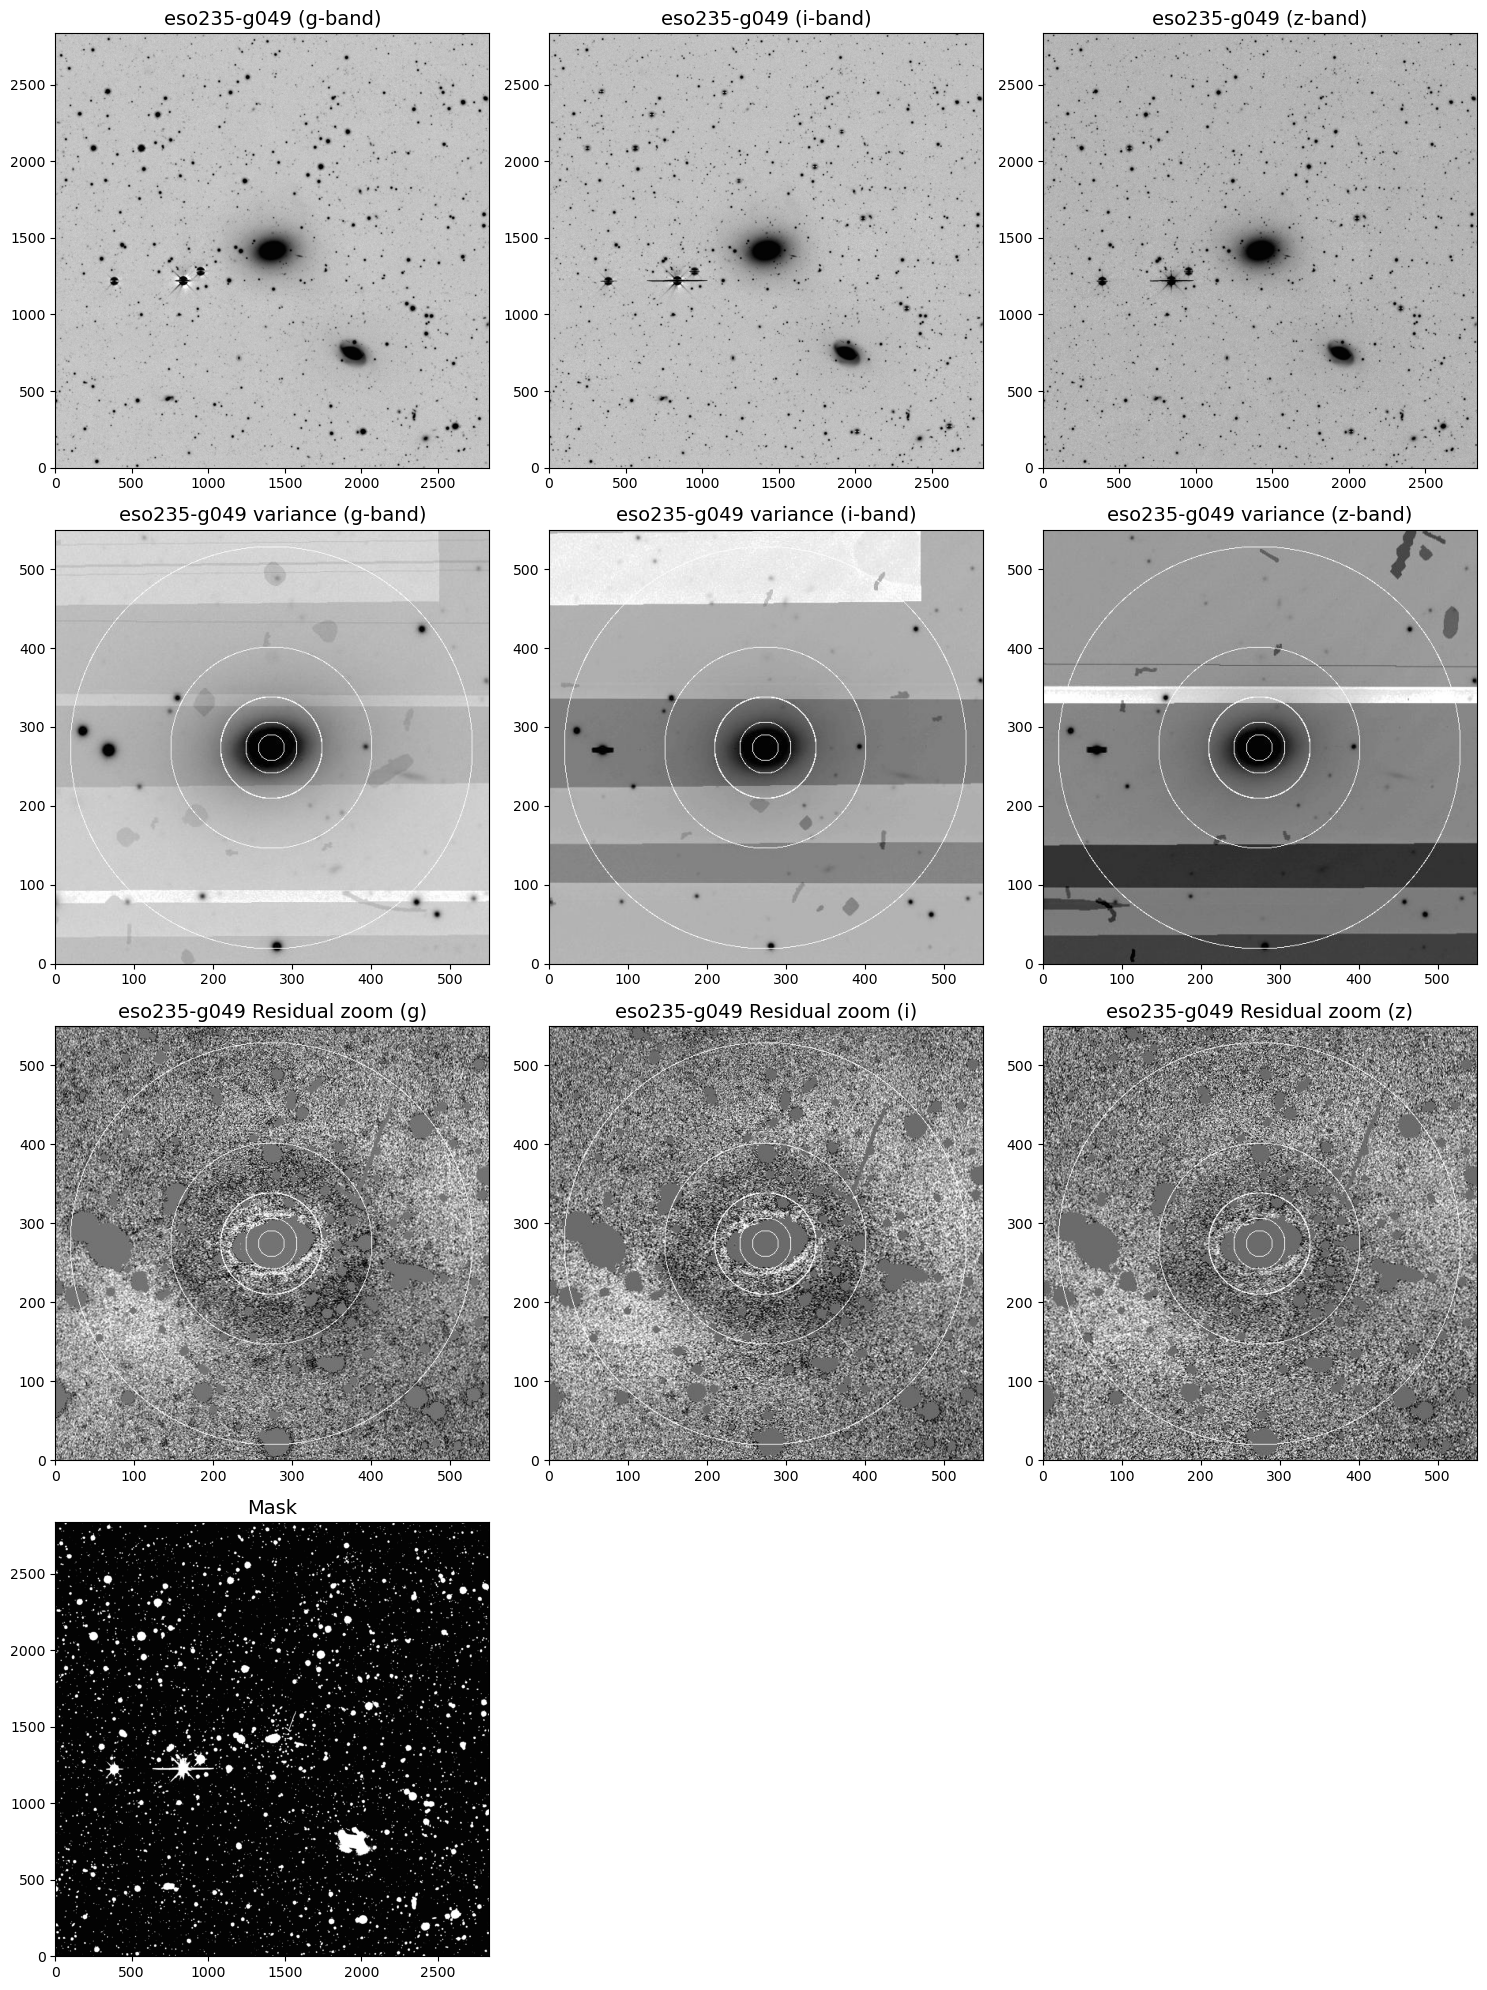

In [16]:
#DC_newmask = outFolder+name+".mask"

plt.figure(tight_layout=True, figsize=(15,20))

plt.subplot(431)
ax = plt.gca()
tv(outFolder+name+'g.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

if noi==False:
    plt.subplot(432)
    ax = plt.gca()
    tv(outFolder+name+'i.nonan',ax=ax, options='sqrt')
    ax.set_title(name + " (i-band)", fontsize=14)

plt.subplot(433)
ax = plt.gca()
tv(outFolder+name+'z.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(434)
ax = plt.gca()
tv(outFolder+name+'gvar.nonan',ax=ax, options='sqrt')
ax.set_title(name + " variance (g-band)", fontsize=14)

if noi==False:
    plt.subplot(435)
    ax = plt.gca()
    tv(outFolder+name+'ivar.nonan',ax=ax, options='sqrt')
    ax.set_title(name + " variance (i-band)", fontsize=14)

plt.subplot(436)
ax = plt.gca()
tv(outFolder+name+'zvar.nonan',ax=ax, options='sqrt')
ax.set_title(name + " variance (z-band)", fontsize=14)

plt.subplot(437)
ax = plt.gca()
tv(outFolder+name+"g.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (g)", fontsize=14)

if noi==False:
    plt.subplot(438)
    ax = plt.gca()
    tv(outFolder+name+"i.zoom.resid",ax=ax, options='')
    ax.set_title(name + " Residual zoom (i)", fontsize=14)

plt.subplot(439)
ax = plt.gca()
tv(outFolder+name+"z.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (z)", fontsize=14)

plt.subplot(4,3,10)
ax = plt.gca()
tv(DC_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

#plt.subplot(4,3,11)
#ax = plt.gca()
##tv(DC_skymask,ax=ax)
#tv(outFolder+name+"tempsky.resid",ax=ax, options='')
#ax.set_title("Sky Mask", fontsize=14)


## Set up the color information file

In [17]:
import json

def save_colors(monsta_log="monsta.log", version="unknown", date="unknown"):
    
    outdict = {}
    radii = []
    extinction = []
    background = []
    npix = []
    gi = []
    gz = []
    gisigma = []
    gzsigma = []
    qualityflaggi = []
    qualityflaggz = []
    inputparams = []
    outdict["Code version"] = version
    outdict["Date and time run"] = date
    outdict["Radii"] = radii
    outdict["Extinction"] = extinction
    outdict["Residual background"] = background
    outdict["Number of unmasked pixels"] = npix
    if (noi==False): 
        outdict["g-i"] = gi
    outdict["g-z"] = gz
    if (noi==False): 
        outdict["g-i uncertainty"] = gisigma
    outdict["g-z uncertainty"] = gzsigma
    if (noi==False): 
        outdict["Quality flags (g-i)"] = qualityflaggi
    outdict["Quality flags (g-z)"] = qualityflaggz
    outdict["Input parameters"] = inputparams
    outdict["Name"] = name
    if pgc!="None":
        outdict["PGC"] = int(pgc)
    else:
        outdict["PGC"] = "None"
    outdict["Color"] = "DECam"
    
    with open("monsta.log", "r") as f:
        lines = f.readlines()

    for l in lines:
        l0 = l.strip()
        l00 = l0.split()
        
        if l00:
            if "EXTG" in l0:
                extinction.append({"Extinction g (mag)": float(l00[1])})
            if (noi==False) & ("EXTI" in l0):
                extinction.append({"Extinction i (mag)": float(l00[1])})
            if "EXTZ" in l0:
                extinction.append({"Extinction z (mag)": float(l00[1])})
            if "SKYG" in l0:
                background.append({"Resid background g (DN)": float(l00[2])})
            if (noi==False) & ("SKYI" in l0):
                background.append({"Resid background i (DN)": float(l00[2])})
            if "SKYZ" in l0:
                background.append({"Resid background z (DN)": float(l00[2])})
            if "Unity" in l0:
                radii.append({"Average_radius (pix)": float(l00[6])})
            if "NPIXGZC0" in l0:
                npix.append({"Number of pixels in (g-z) c0": int(float(l00[1]))})
            if "NPIXGZC1" in l0:
                npix.append({"Number of pixels in (g-z) c1": int(float(l00[1]))})
            if "NPIXGZC2" in l0:
                npix.append({"Number of pixels in (g-z) c2": int(float(l00[1]))})
            if "NPIXGZC5" in l0:
                npix.append({"Number of pixels in (g-z) c5": int(float(l00[1]))})
            if (noi==False) & ("NPIXGIC0" in l0):
                npix.append({"Number of pixels in (g-i) c0": int(float(l00[1]))})
            if (noi==False) & ("NPIXGIC1" in l0):
                npix.append({"Number of pixels in (g-i) c1": int(float(l00[1]))})
            if (noi==False) & ("NPIXGIC2" in l0):
                npix.append({"Number of pixels in (g-i) c2": int(float(l00[1]))})
            if (noi==False) & ("NPIXGIC5" in l0):
                npix.append({"Number of pixels in (g-i) c5": int(float(l00[1]))})
            if (noi==False) & ("GIC0 " in l0):
                if float(l00[2])==0.0:
                    gi.append({"(g-i) in c0": float('nan')})
                else:
                    gi.append({"(g-i) in c0": float(l00[2])})
            if (noi==False) & ("GIC1 " in l0):
                if float(l00[2])==0.0:
                    gi.append({"(g-i) in c1": float('nan')})
                else:
                    gi.append({"(g-i) in c1": float(l00[2])})
            if (noi==False) & ("GIC2 " in l0):
                if float(l00[2])==0.0:
                    gi.append({"(g-i) in c2": float('nan')})
                else:
                    gi.append({"(g-i) in c2": float(l00[2])})
            if (noi==False) & ("GIC5 " in l0):
                if float(l00[2])==0.0:
                    gi.append({"(g-i) in c5": float('nan')})
                else:
                    gi.append({"(g-i) in c5": float(l00[2])})
            if (noi==False) & ("GISIGC0" in l0):
                if float(l00[2])==0.0:
                    gisigma.append({"(g-i) sigma in c0": float('nan')})
                else:
                    gisigma.append({"(g-i) sigma in c0": float(l00[2])})
            if (noi==False) & ("GISIGC1" in l0):
                if float(l00[2])==0.0:
                    gisigma.append({"(g-i) sigma in c1": float('nan')})
                else:
                    gisigma.append({"(g-i) sigma in c1": float(l00[2])})
            if (noi==False) & ("GISIGC2" in l0):
                if float(l00[2])==0.0:
                    gisigma.append({"(g-i) sigma in c2": float('nan')})
                else:
                    gisigma.append({"(g-i) sigma in c2": float(l00[2])})
            if (noi==False) & ("GISIGC5" in l0):
                if float(l00[2])==0.0:
                    gisigma.append({"(g-i) sigma in c5": float('nan')})
                else:
                    gisigma.append({"(g-i) sigma in c5": float(l00[2])})

            if "GZC0 " in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c0": float('nan')})
                else:
                    gz.append({"(g-z) in c0": float(l00[2])})
            if "GZC1 " in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c1": float('nan')})
                else:
                    gz.append({"(g-z) in c1": float(l00[2])})
            if "GZC2 " in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c2": float('nan')})
                else:
                    gz.append({"(g-z) in c2": float(l00[2])})
            if "GZC5 " in l0:
                if float(l00[2])==0.0:
                    gz.append({"(g-z) in c5": float('nan')})
                else:
                    gz.append({"(g-z) in c5": float(l00[2])})
            if "GZSIGC0" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c0": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c0": float(l00[2])})
            if "GZSIGC1" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c1": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c1": float(l00[2])})
            if "GZSIGC2" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c2": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c2": float(l00[2])})
            if "GZSIGC5" in l0:
                if float(l00[2])==0.0:
                    gzsigma.append({"(g-z) sigma in c5": float('nan')})
                else:
                    gzsigma.append({"(g-z) sigma in c5": float(l00[2])})
            if "FLAGGZC0" in l0:
                qualityflaggz.append({"(g-z) c0 flag": int(float(l00[1]))})
            if "FLAGGZC1" in l0:
                qualityflaggz.append({"(g-z) c1 flag": int(float(l00[1]))})
            if "FLAGGZC2" in l0:
                qualityflaggz.append({"(g-z) c2 flag": int(float(l00[1]))})
            if "FLAGGZC5" in l0:
                qualityflaggz.append({"(g-z) c5 flag": int(float(l00[1]))})
            if (noi==False) & ("FLAGGIC0" in l0):
                qualityflaggi.append({"(g-i) c0 flag": int(float(l00[1]))})
            if (noi==False) & ("FLAGGIC1" in l0):
                qualityflaggi.append({"(g-i) c1 flag": int(float(l00[1]))})
            if (noi==False) & ("FLAGGIC2" in l0):
                qualityflaggi.append({"(g-i) c2 flag": int(float(l00[1]))})
            if (noi==False) & ("FLAGGIC5" in l0):
                qualityflaggi.append({"(g-i) c5 flag": int(float(l00[1]))})
            if "Photometric zero point uncertainty g (mag):" in l0:
                inputparams.append({"Photometric zero point uncertainty g (mag)": float(l00[6])})
            if (noi==False) & ("Photometric zero point uncertainty i (mag):" in l0):
                inputparams.append({"Photometric zero point uncertainty i (mag)": float(l00[6])})
            if "Photometric zero point uncertainty z (mag):" in l0:
                inputparams.append({"Photometric zero point uncertainty z (mag)": float(l00[6])})
            if "(g-z) extinction uncertainty (mag)" in l0:
                extinction.append({"(g-z) extinction uncertainty (mag)": float(l00[4])})
            if (noi==False) & ("(g-i) extinction uncertainty (mag)" in l0):
                extinction.append({"(g-i) extinction uncertainty (mag)": float(l00[4])})
            if "RMS" in l0:
                inputparams.append({"RMS limit for inclusion (mag)": float(l00[5])})
                       
    json_name = outFolder+name+"_color_dc.json"
    with open(json_name, 'w') as file:
        json_string = json.dumps(outdict, default=lambda o: o.__dict__, sort_keys=True, indent=2)
        file.write(json_string)

        print("Colors are stored in: ", json_name)

    return json_name


## Measure $(g-z)$

In [18]:
# create the color map and measure the color in monsta
now = datetime.now()

# buffer definitions for monsta:
# 1: g
# 2: var_g (variance g)
# 3: z
# 4: var_z
# 23: i
# 24: var_i
# 5: object+line mask
# 6: c0 annular mask
# 7: c1 annular mask
# 8: c2 annular mask
# 9: c5 annular mask
# 11: g (converted to mag)
# 12: sig g
# 13: z (converted to mag)
# 14: sig z

photvarg = photouncertg * photouncertg
photvari = photouncerti * photouncerti
photvarz = photouncertz * photouncertz
extvargz = sigmaextgz * sigmaextgz
extvargi = sigmaextgi * sigmaextgi

# We don't always have i-band images; proceed with g-z
if (noi==True): 
    gi=0
else:
    gi=1

rmslimit = 0.5 # emperical limit for rms (in mag)

monsta_script = """
    string name '"""+name+"""'
    string gext '"""+str(gext)+"""'
    string iext '"""+str(iext)+"""'
    string zext '"""+str(zext)+"""'
    set flaggzc0=1 flaggzc1=1 flaggzc2=1 flaggzc5=1
    set flaggic0='"""+str(gi)+"""' 
    set flaggic1='"""+str(gi)+"""' 
    set flaggic2='"""+str(gi)+"""' 
    set flaggic5='"""+str(gi)+"""' 

    rd 1 '"""+g_fits+"""'
    rd 2 '"""+g_var+"""'
    rd 23 '"""+i_fits+"""'
    rd 24 '"""+i_var+"""'
    rd 3 '"""+z_fits+"""'
    rd 4 '"""+z_var+"""'
    rd 5 '"""+DC_mask+"""'
    mi 1 5
    mi 2 5
    mi 3 5
    mi 4 5
    mi 23 5
    mi 24 5
    
    ! subtract residual background levels; the subtracted sky levels are not smooth, so let's ditch it for now
    rd 6 '"""+DC_skymask+"""'
    cop 7 1
    mi 7 6
    abx 7 all median median=skyg silent
    cop 7 3
    mi 7 6
    abx 7 all median median=skyz silent
    cop 7 23
    mi 7 6
    abx 7 all median median=skyi silent
    ! sc 1 skyg
    ! sc 3 skyz
    ! sc 23 skyi
    ! mi 1 5
    ! mi 3 5
    ! mi 23 5
    set skyg=0 skyz=0 skyi=0

    ! create annular masks (why not window down the input files to make smaller images here?)
    open 6 nc=8192 nr=8192
    open 7 nc=8192 nr=8192
    open 8 nc=8192 nr=8192
    open 9 nc=8192 nr=8192
    fluc 6 5 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=15.6 r1=31.1 a0=0 a1=360 ! c0
    fluc 7 5 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=31.1 r1=62.3 a0=0 a1=360 ! c1
    fluc 8 5 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=62.3 r1=124.6 a0=0 a1=360 ! c2
    fluc 9 5 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=124.6 r1=249.2 a0=0 a1=360 ! c5
    
    ! This part is just for testing. Not sure how to scale the variance correctly. 0.1 is a guess.
    ! Scale up the variance images to match the data in c0
    !cop 11 1
    !cop 12 2
    !box 1 nc=20 nr=20 cx="""+xcenter+""" cy="""+ycenter+"""
    !abx 11 1 total=tot silent
    !abx 12 1 total=var silent
    !set scaleg=0.1*tot/var
    !mc 2 scaleg
    !typ scaleg
    !cop 13 3
    !cop 14 4
    !abx 13 box=1 total=tot silent
    !abx 14 box=1 total=var silent
    !set scalez=0.1*tot/var
    !mc 4 scalez
    !typ scalez
    
    ! Make color images for display and get the rms values to identify bad regions
    cop 11 1
    cop 12 3
    log 11
    log 12
    mc 11 -2.5
    mc 12 -2.5
    sc 11 """+str(gext)+"""
    sc 12 """+str(zext)+"""
    cop 13 11
    si 13 12
    mi 13 5
    wd 13 '"""+outFolder+name+"""gz.clr'
    cop 14 13
    mi 14 6
    wd 14 '"""+outFolder+"""tmpgzc0.fits'
    abx 14 all rms=rmsc0 silent
    cop 14 13
    mi 14 7
    wd 14 '"""+outFolder+"""tmpgzc1.fits'
    abx 14 all rms=rmsc1 silent
    cop 14 13
    mi 14 8
    wd 14 '"""+outFolder+"""tmpgzc2.fits'
    abx 14 all rms=rmsc2 silent
    cop 14 13
    mi 14 9
    wd 14 '"""+outFolder+"""tmpgzc5.fits'
    abx 14 all rms=rmsc5 silent
    rd 14 '"""+outFolder+name+"""tempcircle.mask'
    ac 13 1.
    mi 13 14
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 13 box=1
    wd 13 '"""+outFolder+name+"""gz.zoom.clr'
    close 11
    close 12
    close 13
    close 14
    if rmsc1>"""+str(rmslimit)+"""
        set flaggzc1=0
    end_if
    if rmsc2>"""+str(rmslimit)+"""
        set flaggzc2=0
    end_if
    if rmsc5>"""+str(rmslimit)+"""
        set flaggzc5=0
    end_if

    if flaggic0>0 
    cop 11 1
    cop 12 23
    log 11
    log 12
    mc 11 -2.5
    mc 12 -2.5
    sc 11 """+str(gext)+"""
    sc 12 """+str(iext)+"""
    cop 13 11
    si 13 12
    mi 13 5
    wd 13 '"""+outFolder+name+"""gi.clr'
    cop 14 13
    mi 14 6
    wd 14 '"""+outFolder+"""tmpgic0.fits'
    abx 14 all rms=rmsc0 silent
    cop 14 13
    mi 14 7
    wd 14 '"""+outFolder+"""tmpgic1.fits'
    abx 14 all rms=rmsc1 silent
    cop 14 13
    mi 14 8
    wd 14 '"""+outFolder+"""tmpgic2.fits'
    abx 14 all rms=rmsc2 silent
    cop 14 13
    mi 14 9
    wd 14 '"""+outFolder+"""tmpgic5.fits'
    abx 14 all rms=rmsc5 silent
    rd 14 '"""+outFolder+name+"""tempcircle.mask'
    ac 13 1.
    mi 13 14
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 13 box=1
    wd 13 '"""+outFolder+name+"""gi.zoom.clr'
    close 11
    close 12
    close 13
    close 14
    if rmsc1>"""+str(rmslimit)+"""
        set flaggic1=0
    end_if
    if rmsc2>"""+str(rmslimit)+"""
        set flaggic2=0
    end_if
    if rmsc5>"""+str(rmslimit)+"""
        set flaggic5=0
    end_if
    end_if
    
     ! c0 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 6
    mi 12 6
    mi 13 6
    mi 14 6
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgzc0=total/mean$nint
    else
        set npixgzc0=0
        set flaggzc0=0
    end_if
    if npixgzc0<400
        set flaggzc0=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggzc0=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flaggzc0=0
    end_if
    set gzc0=magg-magz*flaggzc0
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc0=sigg+sigz
    set gzsigc0=gzsigc0+"""+str(extvargz)+"""$sqrt
    set gzsigc1=gzsigc0*flaggzc0

    cop 11 1
    cop 12 2
    cop 13 23
    cop 14 24
    mi 11 6
    mi 12 6
    mi 13 6
    mi 14 6
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgic0=total/mean$nint
    else
        set npixgic0=0
        set flaggic0=0
    end_if
    if npixgic0<400
        set flaggic0=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumi silent
    abx 14 all total=sumvari silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggic0=0
    end_if
    if sumi>0
        set magi=sumi$log
        set magi=-2.5*magi-"""+str(iext)+"""
    else
        set magi=0
        set flaggic0=0
    end_if
    set gic0=magg-magi*flaggic0
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvari$sqrt
    set tempmax=sumi+tempa
    set tempmin=sumi-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic0=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigi=tempmin-tempmax/2
    else
        set tempmin=0
        set sigi=tempmax-magi
    end_if
    set sigi=sigi*sigi+"""+str(photvari)+"""
    set gisigc0=sigg+sigi
    set gisigc0=gisigc0+"""+str(extvargi)+"""$sqrt
    set gisigc0=gisigc0*flaggic0

    ! c1 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 7
    mi 12 7
    mi 13 7
    mi 14 7
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgzc1=total/mean$nint
    else
        set npixgzc1=0
        set flaggzc1=0
    end_if
    if npixgzc1<1800
        set flaggzc1=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggzc1=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flaggzc1=0
    end_if
    set gzc1=magg-magz*flaggzc1
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc1=sigg+sigz
    set gzsigc1=gzsigc1+"""+str(extvargz)+"""$sqrt
    set gzsigc1=gzsigc1*flaggzc1

    cop 11 1
    cop 12 2
    cop 13 23
    cop 14 24
    mi 11 7
    mi 12 7
    mi 13 7
    mi 14 7
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgic1=total/mean$nint
    else
        set npixgic1=0
        set flaggic1=0
    end_if
    if npixgic1<1800
        set flaggic1=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumi silent
    abx 14 all total=sumvari silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggic1=0
    end_if
    if sumi>0
        set magi=sumi$log
        set magi=-2.5*magi-"""+str(iext)+"""
    else
        set magi=0
        set flaggic1=0
    end_if
    set gic1=magg-magi*flaggic1
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvari$sqrt
    set tempmax=sumi+tempa
    set tempmin=sumi-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic1=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigi=tempmin-tempmax/2
    else
        set tempmin=0
        set sigi=tempmax-magi
    end_if
    set sigi=sigi*sigi+"""+str(photvari)+"""
    set gisigc1=sigg+sigi
    set gisigc1=gisigc1+"""+str(extvargi)+"""$sqrt
    set gisigc1=gisigc1*flaggic1

    ! c2 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 8
    mi 12 8
    mi 13 8
    mi 14 8
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgzc2=total/mean$nint
    else
        set npixgzc2=0
        set flaggzc2=0
    end_if
    if npixgzc2<7300
        set flaggzc2=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggzc2=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flaggzc2=0
    end_if
    set gzc2=magg-magz*flaggzc2
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set sigz=tempmax-magz
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc2=sigg+sigz
    set gzsigc2=gzsigc2+"""+str(extvargz)+"""$sqrt
    set gzsigc2=gzsigc2*flaggzc2

    cop 11 1
    cop 12 2
    cop 13 23
    cop 14 24
    mi 11 8
    mi 12 8
    mi 13 8
    mi 14 8
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgic2=total/mean$nint
    else
        set npixgic2=0
        set flaggic2=0
    end_if
    if npixgic2<7300
        set flaggic2=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumi silent
    abx 14 all total=sumvari silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggic2=0
    end_if
    if sumi>0
        set magi=sumi$log
        set magi=-2.5*magi-"""+str(iext)+"""
    else
        set magi=0
        set flaggic2=0
    end_if
    set gic2=magg-magi*flaggic2
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvari$sqrt
    set tempmax=sumi+tempa
    set tempmin=sumi-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic2=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigi=tempmin-tempmax/2
    else
        set tempmin=0
        set sigi=tempmax-magi
    end_if
    set sigi=sigi*sigi+"""+str(photvari)+"""
    set gisigc2=sigg+sigi
    set gisigc2=gisigc2+"""+str(extvargi)+"""$sqrt
    set gisigc2=gisigc2*flaggic2

    ! c5 ------------
    cop 11 1
    cop 12 2
    cop 13 3
    cop 14 4
    mi 11 9
    mi 12 9
    mi 13 9
    mi 14 9
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgzc5=total/mean$nint
    else
        set npixgzc5=0
        set flaggzc5=0
    end_if
    if npixgzc5<30000
        set flaggzc5=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumz silent
    abx 14 all total=sumvarz silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggzc5=0
    end_if
    if sumz>0
        set magz=sumz$log
        set magz=-2.5*magz-"""+str(zext)+"""
    else
        set magz=0
        set flaggzc5=0
    end_if
    set gzc5=magg-magz*flaggzc5
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvarz$sqrt
    set tempmax=sumz+tempa
    set tempmin=sumz-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggzc5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigz=tempmin-tempmax/2
    else
        set tempmin=0
        set flaggzc5=0
    end_if
    set sigz=sigz*sigz+"""+str(photvarz)+"""
    set gzsigc5=sigg+sigz
    set gzsigc5=gzsigc5+"""+str(extvargz)+"""$sqrt
    set gzsigc5=gzsigc5*flaggzc5

    cop 11 1
    cop 12 2
    cop 13 23
    cop 14 24
    mi 11 9
    mi 12 9
    mi 13 9
    mi 14 9
    abx 11 all total=total mean=mean silent
    if mean>0
        set npixgic5=total/mean$nint
    else
        set npixgic5=0
        set flaggic5=0
    end_if
    if npixgic5<30000
        set flaggic5=0
    end_if
    abx 11 all total=sumg silent
    abx 12 all total=sumvarg silent
    abx 13 all total=sumi silent
    abx 14 all total=sumvari silent
    if sumg>0
        set magg=sumg$log
        set magg=-2.5*magg-"""+str(gext)+"""
    else
        set magg=0
        set flaggic5=0
    end_if
    if sumi>0
        set magi=sumi$log
        set magi=-2.5*magi-"""+str(iext)+"""
    else
        set magi=0
        set flaggic5=0
    end_if
    set gic5=magg-magi*flaggic5
    set tempa=sumvarg$sqrt
    set tempmax=sumg+tempa
    set tempmin=sumg-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigg=tempmin-tempmax/2
    else
        set tempmin=0
        set sigg=tempmax-magg
    end_if
    set sigg=sigg*sigg+"""+str(photvarg)+"""
    set tempa=sumvari$sqrt
    set tempmax=sumi+tempa
    set tempmin=sumi-tempa
    if tempmax>0
        set tempmax=tempmax$log
        set tempmax=-2.5*tempmax
    else
        set tempmax=0
        set flaggic5=0
    end_if
    if tempmin>0
        set tempmin=tempmin$log
        set tempmin=-2.5*tempmin
        set sigi=tempmin-tempmax/2
    else
        set tempmin=0
        set flaggic5=0
    end_if
    set sigi=sigi*sigi+"""+str(photvari)+"""
    set gisigc5=sigg+sigi
    set gisigc5=gisigc5+"""+str(extvargi)+"""$sqrt
    set gisigc5=gisigc5*flaggic5

    printf 'Galaxy: {name}'
    printf 'EXTG: {gext}'
    printf 'EXTI: {iext}'
    printf 'EXTZ: {zext}'
    typ skyg,skyi,skyz
    typ npixgzc0,npixgzc1,npixgzc2,npixgzc5
    typ flaggzc0,flaggzc1,flaggzc2,flaggzc5
    printf ' '
    typ npixgic0,npixgic1,npixgic2,npixgic5
    typ flaggic0,flaggic1,flaggic2,flaggic5
    printf ' '
    printf '{name} (g-z)'
    typ gzc0,gzc1,gzc2,gzc5
    typ gzsigc0,gzsigc1,gzsigc2,gzsigc5
    printf ' '
    printf '{name} (g-i)'
    typ gic0,gic1,gic2,gic5
    typ gisigc0,gisigc1,gisigc2,gisigc5
    printf 'Photometric zero point uncertainty g (mag): """+str(photouncertg)+"""'
    printf 'Photometric zero point uncertainty i (mag): """+str(photouncerti)+"""'
    printf 'Photometric zero point uncertainty z (mag): """+str(photouncertz)+"""'
    printf '(g-z) extinction uncertainty (mag): """+str(sigmaextgz)+"""'
    printf '(g-i) extinction uncertainty (mag): """+str(sigmaextgi)+"""'
    printf 'RMS threshold for inclusion (mag): """+str(rmslimit)+"""'    
"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

json_name = save_colors(monsta_log="monsta.log", version=str(version), date=str(now))


Colors are stored in:  /Users/Joe/data/wfc3-16262/DECam/eso235-g049/DC_Outputs_eso235-g049/eso235-g049_color_dc.json


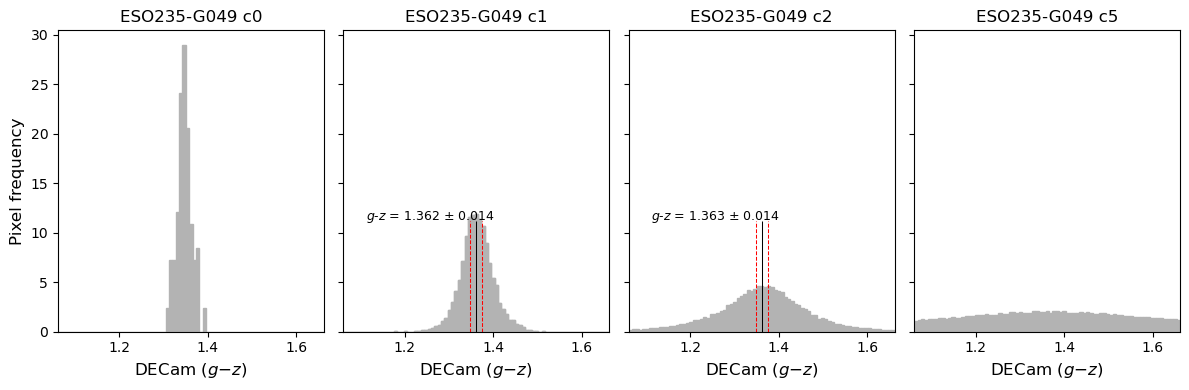

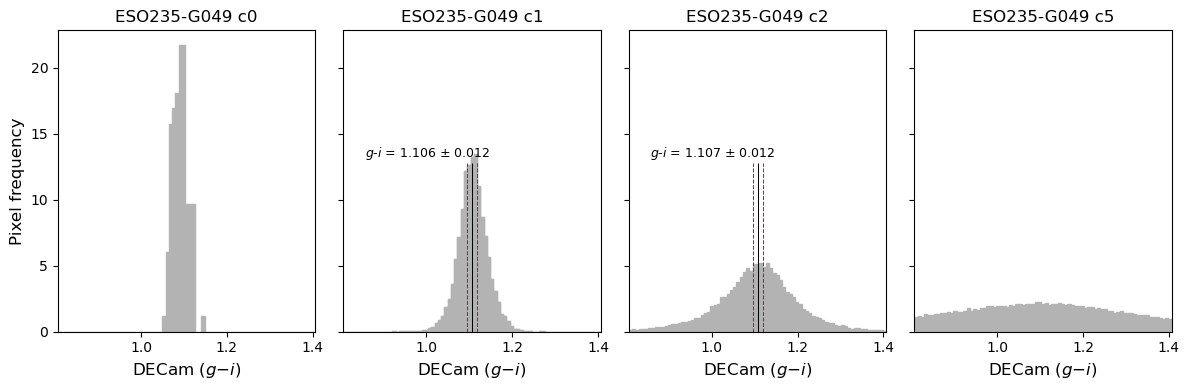

In [19]:
# Plot histograms of the color annuli

# Get stored values output from monsta:
with open(json_name, 'r') as file:
    data = json.load(file)    
name = data["Name"]
colorsgz = [list(d.values())[0] for d in data["g-z"]]
colorsigmagz = [list(d.values())[0] for d in data["g-z uncertainty"]]
gzflags = [list(d.values())[0] for d in data["Quality flags (g-z)"]]
if noi==False: 
    colorsgi = [list(d.values())[0] for d in data["g-i"]]
    colorsigmagi = [list(d.values())[0] for d in data["g-i uncertainty"]]
    giflags = [list(d.values())[0] for d in data["Quality flags (g-i)"]]

histcolor='0.7'  # histogram color
linewidth=0.75

color = data["Color"] + ' $(g{{-}}z)$'
tmpim0, _ = imOpen(outFolder+"tmpgzc0.fits")
im0 = tmpim0.flatten()
tmpim1, _ = imOpen(outFolder+"tmpgzc1.fits")
im1 = tmpim1.flatten()
tmpim2, _ = imOpen(outFolder+"tmpgzc2.fits")
im2 = tmpim2.flatten()
tmpim3, _ = imOpen(outFolder+"tmpgzc5.fits")
im3 = tmpim3.flatten()

fig, axes = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(12, 4))
#fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

# set the ranges
if gzflags[0]==1:
    ax1.hist(im0, bins=np.linspace(colorsgz[0]-0.3,colorsgz[0]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
    ax1.set_xlim(colorsgz[0]-0.3, colorsgz[0]+0.3)
    xmax = ax1.get_xlim()
    ymax = ax1.get_ylim()
elif gzflags[1]==1:
    ax2.hist(im1, bins=np.linspace(colorsgz[1]-0.3,colorsgz[1]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
    ax2.set_xlim(colorsgz[1]-0.3, colorsgz[1]+0.3)
    xmax = ax2.get_xlim()
    ymax = ax2.get_ylim()   
elif gzflags[2]==1:
    ax3.hist(im2, bins=np.linspace(colorsgz[2]-0.3,colorsgz[2]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
    ax3.set_xlim(colorsgz[2]-0.3, colorsgz[2]+0.3)
    xmax = ax3.get_xlim()
    ymax = ax3.get_ylim()   
else:
    ax4.hist(im3, bins=np.linspace(colorsgz[3]-0.3,colorsgz[3]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
    ax4.set_xlim(colorsgz[3]-0.3, colorsgz[3]+0.3)
    xmax = ax4.get_xlim()
    ymax = ax4.get_ylim()   

ax1.set_xlim(xmax[0],xmax[1])
ax1.set_xlabel(color, fontsize=12)
ax1.set_ylabel("Pixel frequency", fontsize=12)
ax1.set_title(name.upper()+" c0", fontsize=12)

ax2.set_xlim(xmax[0],xmax[1])
ax2.set_xlabel(color, fontsize=12)
ax2.set_title(name.upper()+" c1", fontsize=12)

ax3.set_xlim(xmax[0],xmax[1])
ax3.set_xlabel(color, fontsize=12)
ax3.set_title(name.upper()+" c2", fontsize=12)    

ax4.set_xlim(xmax[0],xmax[1])
ax4.set_xlabel(color, fontsize=12)
ax4.set_title(name.upper()+" c5", fontsize=12)

# make the g-z plots
ax1.hist(im0, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
if gzflags[0]==1:
    #ax1.hist(im0, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    title=rf"$g$-$z$ = {colorsgz[0]:.3f} $\pm$ {colorsigmagz[0]:0.3f}"
    ax1.vlines(colorsgz[0], 0, ymax[1]*0.95, colors='k', linestyles='solid', linewidth=linewidth)
    ax1.vlines(colorsgz[0]+colorsigmagz[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
    ax1.vlines(colorsgz[0]-colorsigmagz[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
    ax1.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

ax2.hist(im1, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
if gzflags[1]==1:
    #ax2.hist(im1, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    title=rf"$g$-$z$ = {colorsgz[1]:.3f} $\pm$ {colorsigmagz[1]:0.3f}"
    ax2.vlines(colorsgz[1], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax2.vlines(colorsgz[1]+colorsigmagz[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax2.vlines(colorsgz[1]-colorsigmagz[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax2.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

ax3.hist(im2, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
if gzflags[2]==1:
    #ax3.hist(im2, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    title=rf"$g$-$z$ = {colorsgz[2]:.3f} $\pm$ {colorsigmagz[2]:0.3f}"
    ax3.vlines(colorsgz[2], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax3.vlines(colorsgz[2]+colorsigmagz[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax3.vlines(colorsgz[2]-colorsigmagz[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax3.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')
    
ax4.hist(im3, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)    
if gzflags[3]==1:
    #ax4.hist(im3, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    title=rf"$g$-$z$ = {colorsgz[3]:.3f} $\pm$ {colorsigmagz[3]:0.3f}"
    ax4.vlines(colorsgz[3], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
    ax4.vlines(colorsgz[3]+colorsigmagz[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax4.vlines(colorsgz[3]-colorsigmagz[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
    ax4.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

plt.savefig(outFolder+name+"-DCgzHistogram.pdf", format='pdf', bbox_inches='tight')
plt.show()

# now plot the g-i histograms, if i-band image exists
if(noi==False):
    color = data["Color"] + ' $(g{{-}}i)$'
    tmpim0, _ = imOpen(outFolder+"tmpgic0.fits")
    im0 = tmpim0.flatten()
    tmpim1, _ = imOpen(outFolder+"tmpgic1.fits")
    im1 = tmpim1.flatten()
    tmpim2, _ = imOpen(outFolder+"tmpgic2.fits")
    im2 = tmpim2.flatten()
    tmpim3, _ = imOpen(outFolder+"tmpgic5.fits")
    im3 = tmpim3.flatten()

    fig, axes = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(12, 4))
    #fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    # set the ranges
    if giflags[0]==1:
        ax1.hist(im0, bins=np.linspace(colorsgi[0]-0.3,colorsgi[0]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
        ax1.set_xlim(colorsgi[0]-0.3, colorsgi[0]+0.3)
        xmax = ax1.get_xlim()
        ymax = ax1.get_ylim()   
    elif giflags[1]==1:
        ax2.hist(im1, bins=np.linspace(colorsgi[1]-0.3,colorsgi[1]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
        ax2.set_xlim(colorsgi[1]-0.3, colorsgi[1]+0.3)
        xmax = ax2.get_xlim()
        ymax = ax2.get_ylim()   
    elif giflags[2]==1:
        ax3.hist(im2, bins=np.linspace(colorsgi[2]-0.3,colorsgi[2]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
        ax3.set_xlim(colorsgi[2]-0.3, colorsgi[2]+0.3)
        xmax = ax3.get_xlim()
        ymax = ax3.get_ylim()   
    else:
        ax4.hist(im3, bins=np.linspace(colorsgi[3]-0.3,colorsgi[3]+0.3,80), density=True, color=histcolor, edgecolor=histcolor)
        ax4.set_xlim(colorsgi[3]-0.3, colorsgi[3]+0.3)
        xmax = ax4.get_xlim()
        ymax = ax4.get_ylim()   

    ax1.set_xlim(xmax[0],xmax[1])
    ax1.set_xlabel(color, fontsize=12)
    ax1.set_ylabel("Pixel frequency", fontsize=12)
    ax1.set_title(name.upper()+" c0", fontsize=12)

    ax2.set_xlim(xmax[0],xmax[1])
    ax2.set_xlabel(color, fontsize=12)
    ax2.set_title(name.upper()+" c1", fontsize=12)

    ax3.set_xlim(xmax[0],xmax[1])
    ax3.set_xlabel(color, fontsize=12)
    ax3.set_title(name.upper()+" c2", fontsize=12)    

    ax4.set_xlim(xmax[0],xmax[1])
    ax4.set_xlabel(color, fontsize=12)
    ax4.set_title(name.upper()+" c5", fontsize=12)

    ax1.hist(im0, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    if giflags[0]==1:
        #ax1.hist(im0, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
        title=rf"$g$-$i$ = {colorsgi[0]:.3f} $\pm$ {colorsigmagi[0]:0.3f}"
        ax1.vlines(colorsgi[0], 0, ymax[1]*0.95, colors='k', linestyles='solid', linewidth=linewidth)
        ax1.vlines(colorsgi[0]+colorsigmagi[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
        ax1.vlines(colorsgi[0]-colorsigmagi[0], 0, ymax[1]*0.95, colors='r', linestyles='dashed', linewidth=0.75)
        ax1.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

    ax2.hist(im1, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    if giflags[1]==1:
        #ax2.hist(im1, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
        title=rf"$g$-$i$ = {colorsgi[1]:.3f} $\pm$ {colorsigmagi[1]:0.3f}"
        ax2.vlines(colorsgi[1], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
        ax2.vlines(colorsgi[1]+colorsigmagi[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax2.vlines(colorsgi[1]-colorsigmagi[1], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax2.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

    ax3.hist(im2, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    if giflags[2]==1:
        #ax3.hist(im2, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
        title=rf"$g$-$i$ = {colorsgi[2]:.3f} $\pm$ {colorsigmagi[2]:0.3f}"
        ax3.vlines(colorsgi[2], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
        ax3.vlines(colorsgi[2]+colorsigmagi[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax3.vlines(colorsgi[2]-colorsigmagi[2], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax3.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')

    ax4.hist(im3, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
    if giflags[3]==1:
        #ax4.hist(im3, bins=np.linspace(xmax[0],xmax[1],80), density=True, color=histcolor, edgecolor=histcolor)
        title=rf"$g$-$i$ = {colorsgi[3]:.3f} $\pm$ {colorsigmagi[3]:0.3f}"
        ax4.vlines(colorsgi[3], 0, ymax[1]*0.9, colors='k', linestyles='solid', linewidth=linewidth)
        ax4.vlines(colorsgi[3]+colorsigmagi[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax4.vlines(colorsgi[3]-colorsigmagi[3], 0, ymax[1]*0.9, colors='r', linestyles='dashed', linewidth=0.75)
        ax4.text(xmax[0]+0.05,ymax[1]-0.05,title, fontsize=9, verticalalignment='top')    

    plt.savefig(outFolder+name+"-DCgiHistogram.pdf", format='pdf', bbox_inches='tight')
    plt.show()

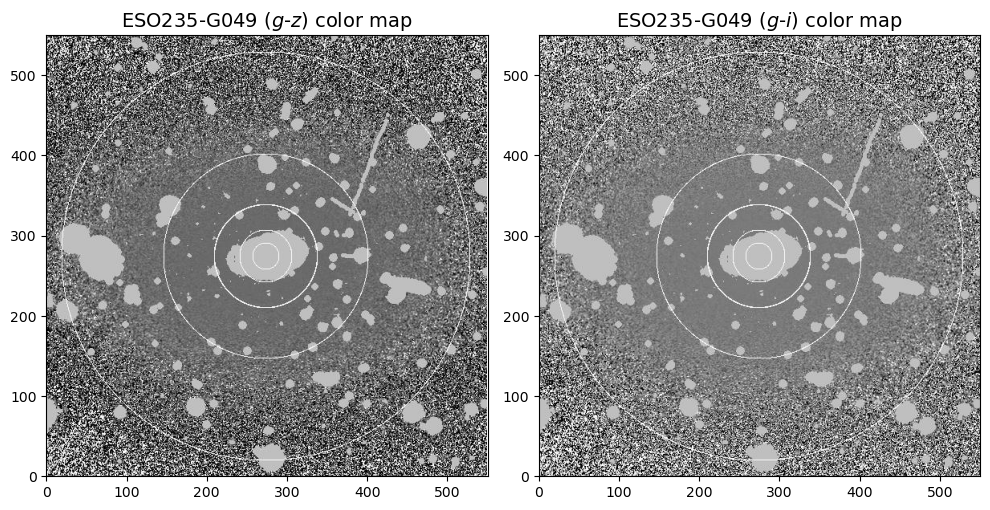

In [20]:
plt.figure(tight_layout=True, figsize=(10,15))
plt.subplot(121)
ax = plt.gca()
tv(outFolder+name+"gz.zoom.clr",ax=ax, options='0 4')
ax.set_title(name.upper() + r" ($g$-$z$) color map", fontsize=14)
if noi==False:
    plt.subplot(122)
    ax = plt.gca()
    tv(outFolder+name+"gi.zoom.clr",ax=ax, options='0 4')
    ax.set_title(name.upper() + r" ($g$-$i$) color map", fontsize=14)

In [21]:
#! cat monsta.log

In [22]:
# print(name)
#!cat {json_name}

In [23]:
# clean up temporary display images
temp = outFolder+name+'*.zoom.*'
!rm {temp}
temp = outFolder+name+'*.nonan'
!rm {temp}
temp = outFolder+name+'*tempsky.resid'
!rm {temp}
temp = outFolder+name+'*tempcircle.mask'
!rm {temp}
#!rm monsta.log
!rm monsta.pro
temp = outFolder+'tmpgi*.fits'
! rm {temp}
temp = outFolder+'tmpgz*.fits'
!rm {temp}